# Cars Classification on the Stanford dataset (fastai)


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai import *
import cv2 as cv

## Looking at the data

In [ ]:
# https://github.com/foamliu/Car-Recognition/blob/master/pre-process.py

import tarfile
import scipy.io
import numpy as np
import os
import cv2 as cv
import shutil
import random
from console_progressbar import ProgressBar


def ensure_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)


def save_train_data(fnames, labels, bboxes):
    src_folder ='//home//jupyter//cars_train//'
    num_samples = len(fnames)

    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)

    pb = ProgressBar(total=100, prefix='Save train data', suffix='', decimals=3, length=50, fill='=')

    for i in range(num_samples):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]

        src_path = os.path.join(src_folder, fname)
        print(src_path)
        src_image = cv.imread(src_path)
        print(src_image)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print("{} -> {}".format(fname, label))
        pb.print_progress_bar((i + 1) * 100 / num_samples)

        if i in train_indexes:
            dst_folder = '//home//jupyter//.fastai//data//train//'
        else:
            dst_folder = '//home//jupyter//.fastai//data//valid//'

        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)

        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)


def save_test_data(fnames, bboxes):
    src_folder = '//home//jupyter//cars_test//'
    dst_folder = '//home//jupyter//.fastai//data//test//'
    num_samples = len(fnames)

    pb = ProgressBar(total=100, prefix='Save test data', suffix='', decimals=3, length=50, fill='=')

    for i in range(num_samples):
        fname = fnames[i]
        (x1, y1, x2, y2) = bboxes[i]
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print(fname)
        pb.print_progress_bar((i + 1) * 100 / num_samples)

        dst_path = os.path.join(dst_folder, fname)
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)


def process_train_data():
    print("Processing train data...")
    cars_annos = scipy.io.loadmat('//home//jupyter//devkit//cars_train_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    class_ids = []
    bboxes = []
    labels = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append('%04d' % (class_id,))
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)

    labels_count = np.unique(class_ids).shape[0]
    print(np.unique(class_ids))
    print('The number of different cars is %d' % labels_count)

    save_train_data(fnames, labels, bboxes)


def process_test_data():
    print("Processing test data...")
    cars_annos = scipy.io.loadmat('//home//jupyter//devkit//cars_test_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    bboxes = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        fname = annotation[0][4][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        fnames.append(fname)

    save_test_data(fnames, bboxes)


if __name__ == '__main__':
    # parameters
    img_width, img_height = 224, 224

    print('Extracting cars_train.tgz...')
    if not os.path.exists('cars_train'):
        with tarfile.open('//home//jupyter//.fastai//data//cars_train.tgz', "r:gz") as tar:
            tar.extractall()
    print('Extracting cars_test.tgz...')
    if not os.path.exists('cars_test'):
        with tarfile.open('//home//jupyter//.fastai//data//cars_test.tgz', "r:gz") as tar:
            tar.extractall()
    print('Extracting car_devkit.tgz...')
    if not os.path.exists('devkit'):
        with tarfile.open('//home//jupyter//.fastai//data//car_devkit.tgz', "r:gz") as tar:
            tar.extractall()

    cars_meta = scipy.io.loadmat('devkit/cars_meta')
    class_names = cars_meta['class_names']  # shape=(1, 196)
    class_names = np.transpose(class_names)
    print('class_names.shape: ' + str(class_names.shape))
    print('Sample class_name: [{}]'.format(class_names[8][0][0]))

    ensure_folder('//home//jupyter//.fastai//data/train')
    ensure_folder('//home//jupyter//.fastai//data/valid')
    ensure_folder('//home//jupyter//.fastai//data/test')

    process_train_data()
    process_test_data()

    # clean up
    shutil.rmtree('cars_train')
    shutil.rmtree('cars_test')
# shutil.rmtree('devkit')

In [70]:

data = ImageDataBunch.from_folder('.fastai/data/','train','valid',ds_tfms=get_transforms(do_flip=False, flip_vert=True, max_rotate=5.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75),size=224,bs=32).normalize(imagenet_stats)

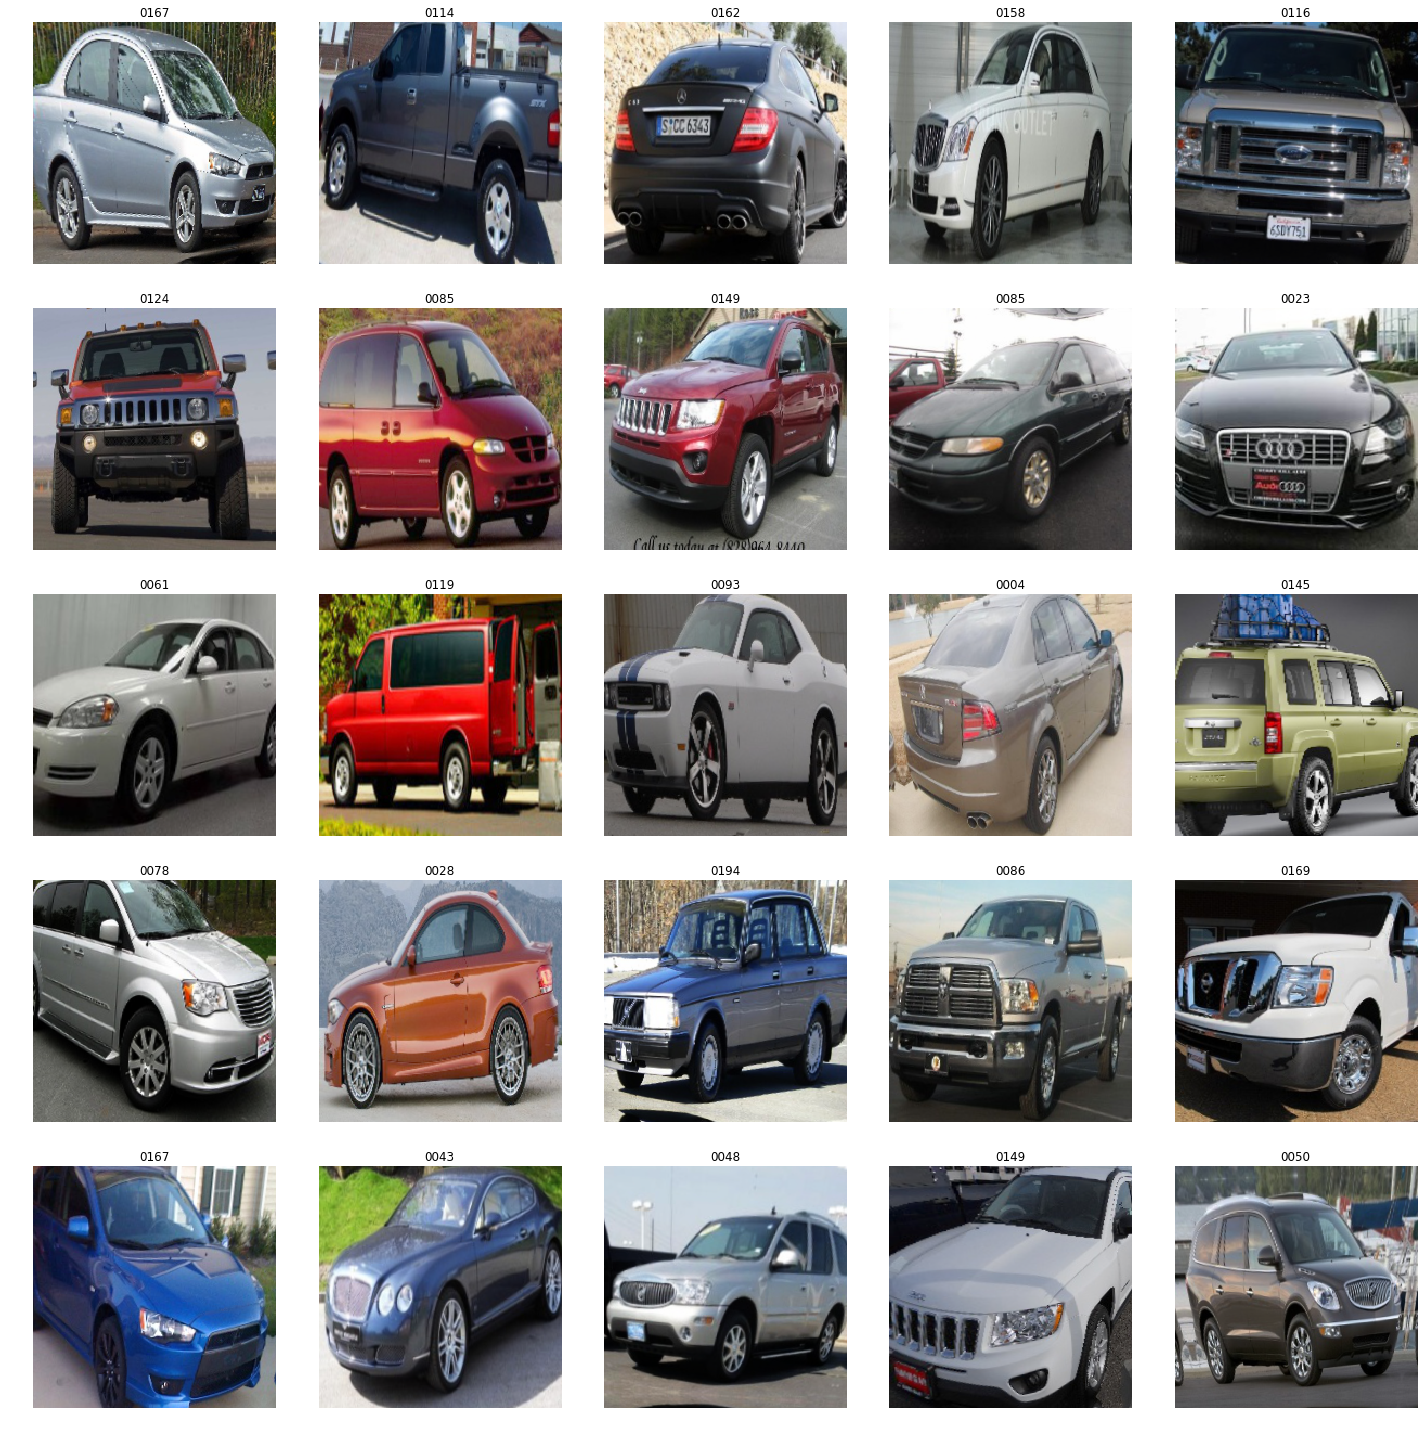

In [71]:
data.show_batch()

In [72]:
print(data.classes)
len(data.classes),data.c


['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030', '0031', '0032', '0033', '0034', '0035', '0036', '0037', '0038', '0039', '0040', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0049', '0050', '0051', '0052', '0053', '0054', '0055', '0056', '0057', '0058', '0059', '0060', '0061', '0062', '0063', '0064', '0065', '0066', '0067', '0068', '0069', '0070', '0071', '0072', '0073', '0074', '0075', '0076', '0077', '0078', '0079', '0080', '0081', '0082', '0083', '0084', '0085', '0086', '0087', '0088', '0089', '0090', '0091', '0092', '0093', '0094', '0095', '0096', '0097', '0098', '0099', '0100', '0101', '0102', '0103', '0104', '0105', '0106', '0107', '0108', '0109', '0110', '0111', '0112', '0113', '0114', '0115', '0116', '0117', '0118', '0119', '0120', '0121', '0122', '0123', '0124', '0125',

(196, 196)

## Training: resne50

In [73]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

In [52]:
learn.fit_one_cycle(4)
preds,y, loss = learn.get_preds(with_loss=True)



In [53]:
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.6224677562713623 %.


In [54]:
learn.save('stanford-cars-1')

## Results

In [55]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

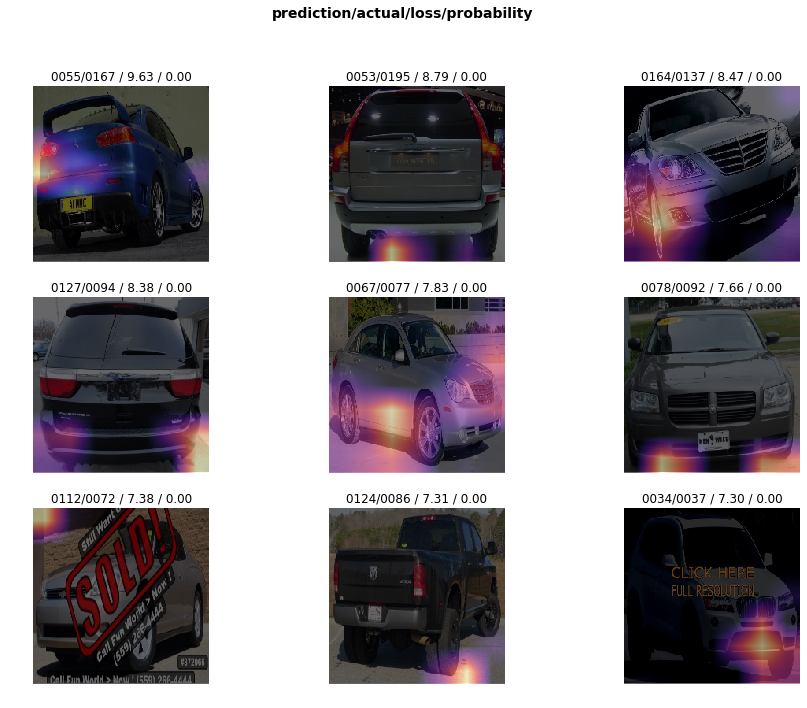

In [56]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
doc(interp.plot_top_losses)

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [74]:
learn.unfreeze()

In [42]:
learn.load('stanford-cars-1');

In [75]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


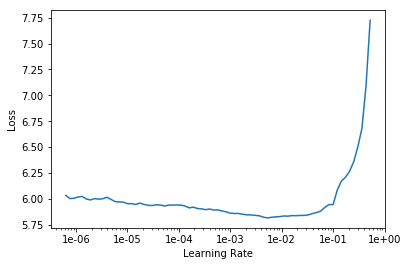

In [76]:
learn.recorder.plot()

In [77]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,3.980040,2.892502,0.311848,01:31
1,2.487354,2.167235,0.445058,01:32
2,2.109999,1.529038,0.590546,01:33
3,1.548193,1.437101,0.611418,01:33
4,1.069342,0.967165,0.742787,01:33
5,0.709701,0.819891,0.793125,01:33
6,0.405046,0.690320,0.819521,01:33
7,0.209479,0.525795,0.861265,01:33
8,0.115298,0.456329,0.877839,01:33
9,0.072730,0.448345,0.885206,01:33


That's a pretty accurate model!